# Biomarkers for palbociclib - Workbook 2 June 2023 

## Import Data

In [1]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)


## Palbociclib GDSC with Goncalves et al proteomics (preprocessed & normalised)

In [2]:
# create feature and target 

import DataFunctions as utils

drug_selected = 'Palbociclib'

# create the full dataset

palbociclib_proteomic_df = utils.create_joint_dataset_from_proteome_gdsc(drug_selected, joined_sin_peptile_exclusion_matrix, gdsc2)

feature_data, label_data = utils.create_feature_and_label(palbociclib_proteomic_df)



### Computing Interactors

In [3]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target
import pickle 
import pandas as pd

drug_targets = ['CDK4', 'CDK6']
first_degree_neighbours = []
second_degree_neighbours = []
third_degree_neighbours = []

for drug_target in drug_targets:
    string_id = utils.get_protein_id_by_name(drug_target, string_df_info, string_df_alias)
    if string_id is not None:
        first_interactors_string_id = utils.get_protein_interactors(string_id, string_df, score_threshold=900)
        for ii in first_interactors_string_id:
            interactor_name = utils.get_protein_name_by_id(ii, goncalve_to_string_id_df, 
                                                           field_name='goncalve_protein_id',
                                                           check_field_name='string_protein_id')
            if interactor_name is not None:
                first_degree_neighbours.append(interactor_name)

first_degree_neighbours = list(set(first_degree_neighbours))

print(f'first degree neighbours size: {len(first_degree_neighbours)}')
print(f'first degree neighbours: {first_degree_neighbours}')
# get the second degree neighbours using first_interactors_string_id

for ii in first_interactors_string_id:
    second_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for sec_ii in second_interactors_string_id:
        interactor_name = utils.get_protein_name_by_id(sec_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            second_degree_neighbours.append(interactor_name)

second_degree_neighbours = list(set(second_degree_neighbours + first_degree_neighbours))
print(f'second degree neighbours size: {len(second_degree_neighbours)}')
print(f'second degree neighbours: {second_degree_neighbours}')


# get the third degree neighbours using second_interactors_string_id

for ii in second_interactors_string_id:
    third_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for third_ii in third_interactors_string_id:
        interactor_name = utils.get_protein_name_by_id(third_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            third_degree_neighbours.append(interactor_name)

third_degree_neighbours = list(set(third_degree_neighbours + second_degree_neighbours))
print(f'third degree neighbours size: {len(third_degree_neighbours)}')
print(f'third degree neighbours: {third_degree_neighbours}')
# verify a list is unique

def verify_unique_list(l):
    return len(l) == len(set(l))

# find duplicates in the list

def find_duplicates(l):
    return list(set([x for x in l if l.count(x) > 1]))

print(f'first degree neighbours is unique: {verify_unique_list(first_degree_neighbours)}')
print(f'second degree neighbours is unique: {verify_unique_list(second_degree_neighbours)}')
print(f'third degree neighbours is unique: {verify_unique_list(third_degree_neighbours)}')

# print the duplicates in first degree neighbours

print(f'duplicates in first degree neighbours: {find_duplicates(first_degree_neighbours)}')
print(f'duplicates in second degree neighbours: {find_duplicates(second_degree_neighbours)}')
print(f'duplicates in third degree neighbours: {find_duplicates(third_degree_neighbours)}')

# save result to pickle
# filepath = data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl

n_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'wb') as f:
    pickle.dump(n_degree_neighbours, f)

first degree neighbours size: 43
first degree neighbours: ['Q00535;CDK5_HUMAN', 'P07948;LYN_HUMAN', 'P24941;CDK2_HUMAN', 'Q9BWT6;MND1_HUMAN', 'Q16543;CDC37_HUMAN', 'Q13951;PEBB_HUMAN', 'P08238;HS90B_HUMAN', 'Q13309;SKP2_HUMAN', 'P12004;PCNA_HUMAN', 'P31947;1433S_HUMAN', 'P12931;SRC_HUMAN', 'O43502;RA51C_HUMAN', 'P42771;CDN2A_HUMAN', 'P15090;FABP4_HUMAN', 'P16989;YBOX3_HUMAN', 'P10275;ANDR_HUMAN', 'P11802;CDK4_HUMAN', 'P20248;CCNA2_HUMAN', 'P49715;CEBPA_HUMAN', 'O60563;CCNT1_HUMAN', 'P50613;CDK7_HUMAN', 'O95067;CCNB2_HUMAN', 'P24385;CCND1_HUMAN', 'P51948;MAT1_HUMAN', 'P06493;CDK1_HUMAN', 'Q14186;TFDP1_HUMAN', 'P50750;CDK9_HUMAN', 'P42773;CDN2C_HUMAN', 'Q9P2W1;HOP2_HUMAN', 'P14635;CCNB1_HUMAN', 'P00519;ABL1_HUMAN', 'P07900;HS90A_HUMAN', 'Q13485;SMAD4_HUMAN', 'P06400;RB_HUMAN', 'O75832;PSD10_HUMAN', 'Q13547;HDAC1_HUMAN', 'P51946;CCNH_HUMAN', 'P49918;CDN1C_HUMAN', 'Q00534;CDK6_HUMAN', 'Q9P287;BCCIP_HUMAN', 'P84022;SMAD3_HUMAN', 'P04637;P53_HUMAN', 'P49841;GSK3B_HUMAN']
second degree neighb

### Explore statistical correlations between palbociclib IC50 and protein expression

In [111]:
## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# select the top 10 features using f_regression
top_10_features = SelectKBest(f_regression, k=10).fit_transform(feature_data, label_data)

# get the feature names and the scores
feature_names = feature_data.columns
feature_scores = SelectKBest(f_regression, k=10).fit(feature_data, label_data).scores_

# create a dataframe to store the feature names and scores
feature_score_df = pd.DataFrame({'feature_name': feature_names, 'feature_score': feature_scores})

# sort the dataframe by feature scores
feature_score_df.sort_values(by=['feature_score'], ascending=False, inplace=True)

# print the top 10 features
feature_score_df



,feature_name,feature_score
3771,O95292;VAPB_HUMAN,255.457967
2525,Q92556;ELMO1_HUMAN,242.434047
552,Q13422;IKZF1_HUMAN,240.901719
5002,P15151;PVR_HUMAN,239.330090
4138,Q92608;DOCK2_HUMAN,235.597072
...,...,...
2787,P35713;SOX18_HUMAN,0.000000
4717,Q8WWA0;ITLN1_HUMAN,0.000000
6638,P07202;PERT_HUMAN,0.000000
4724,Q8WWU7;ITLN2_HUMAN,0.000000


### Explore effects of feature size to performance

In [12]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle

feature_size_tested = []
for i in range(1, 500, 10):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        random_features = np.random.choice(X_train.columns, f_size, replace=False)
        X_train = X_train[random_features]
        X_test = X_test[random_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])


An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not d

#### Plot the performance of the model with different feature sizes

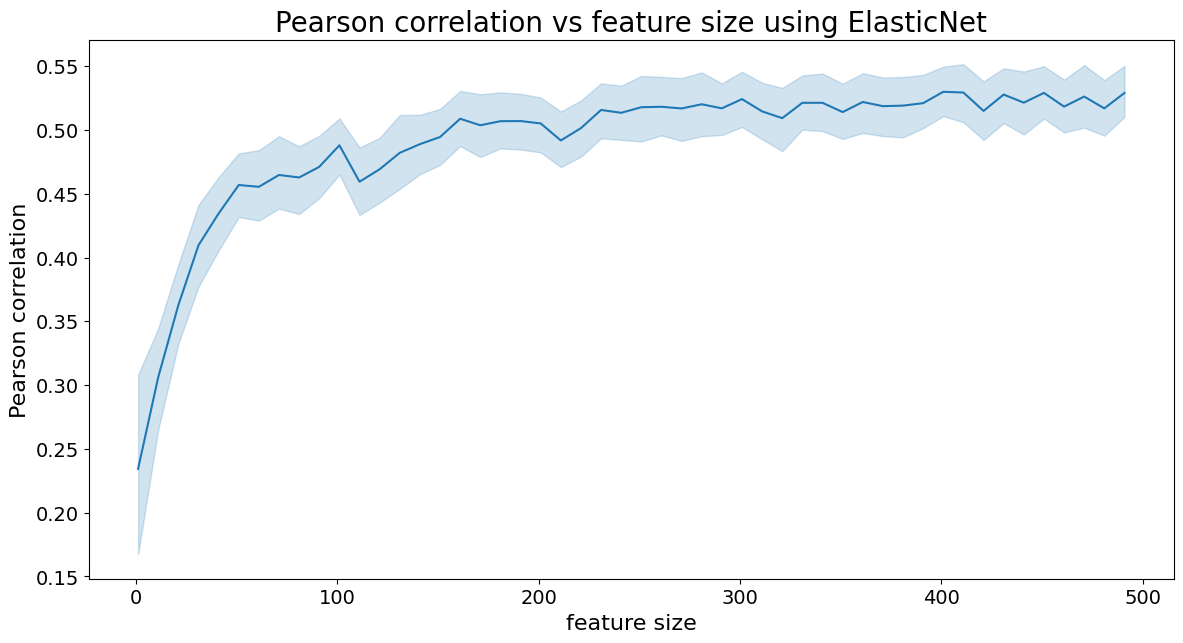

In [5]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()


In [6]:
feature_size_tested = []
for i in range(1, feature_data.shape[1] + 1, 500):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    print(f'feature size: {f_size}')
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        random_features = np.random.choice(X_train.columns, f_size, replace=False)
        X_train = X_train[random_features]
        X_test = X_test[random_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

feature size: 1


An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not d

feature size: 501
feature size: 1001
feature size: 1501
feature size: 2001
feature size: 2501
feature size: 3001
feature size: 3501
feature size: 4001
feature size: 4501
feature size: 5001
feature size: 5501
feature size: 6001
feature size: 6501


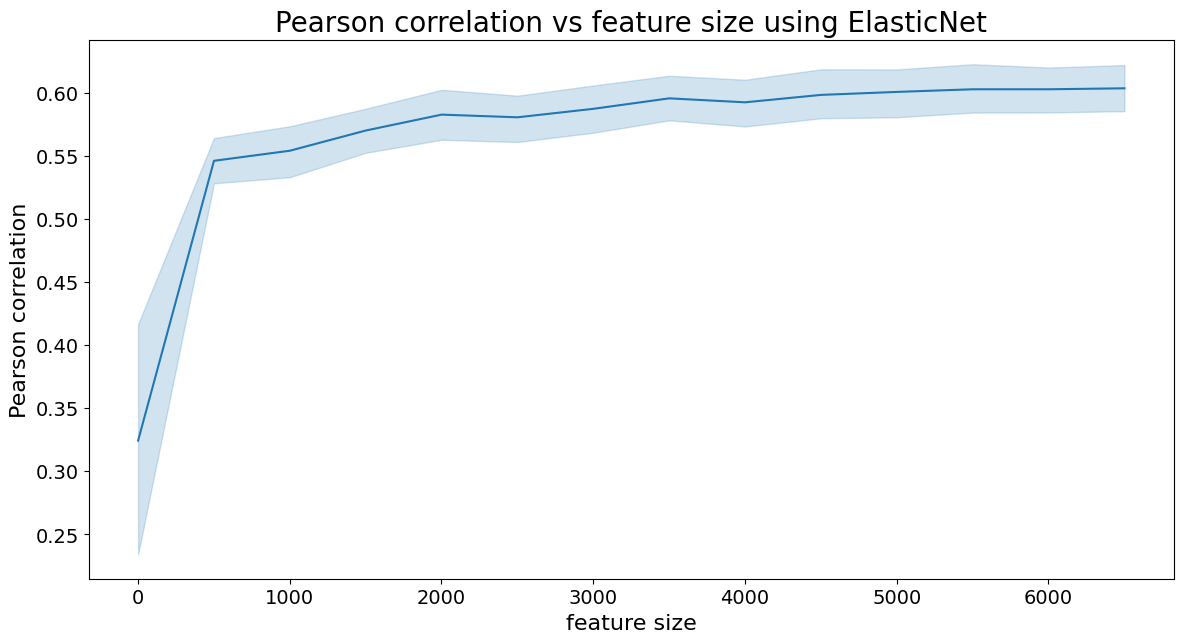

In [7]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()


#### Feature size vs performance with f-regression filtering

In [8]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle

feature_size_tested = []
for i in range(1, 500, 10):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        selector = SelectKBest(f_regression, k=f_size)
        selector.fit(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()]
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # print debug info
        print(f'feature size: {f_size}, rng: {rng}, mse: {mse}, r2: {r2}, pearson_corr: {pearson_corr}')
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

stat_df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

feature size: 1, rng: 607106, mse: 2.2127609952960867, r2: 0.09441150077110005, pearson_corr: 0.41562692879562857
feature size: 1, rng: 14466, mse: 1.7911633179727087, r2: 0.09273042132288689, pearson_corr: 0.36255901814766184
feature size: 1, rng: 925754, mse: 1.7926008723629188, r2: 0.12651980328759316, pearson_corr: 0.48347874795763124
feature size: 1, rng: 741790, mse: 2.0345517558254587, r2: 0.09199832329936919, pearson_corr: 0.3235425831313486
feature size: 1, rng: 583731, mse: 2.19881515856952, r2: 0.06492210020393097, pearson_corr: 0.37466152855774654
feature size: 1, rng: 95049, mse: 2.472366676290522, r2: 0.022737010379406675, pearson_corr: 0.40498762924764264
feature size: 1, rng: 208247, mse: 2.1802262189455255, r2: 0.09432507250927102, pearson_corr: 0.5090207352172167
feature size: 1, rng: 725003, mse: 2.5878671003462186, r2: 0.13439184406260685, pearson_corr: 0.4363339001887866
feature size: 1, rng: 77069, mse: 2.044515934273042, r2: 0.06345992916290855, pearson_corr: 0.3

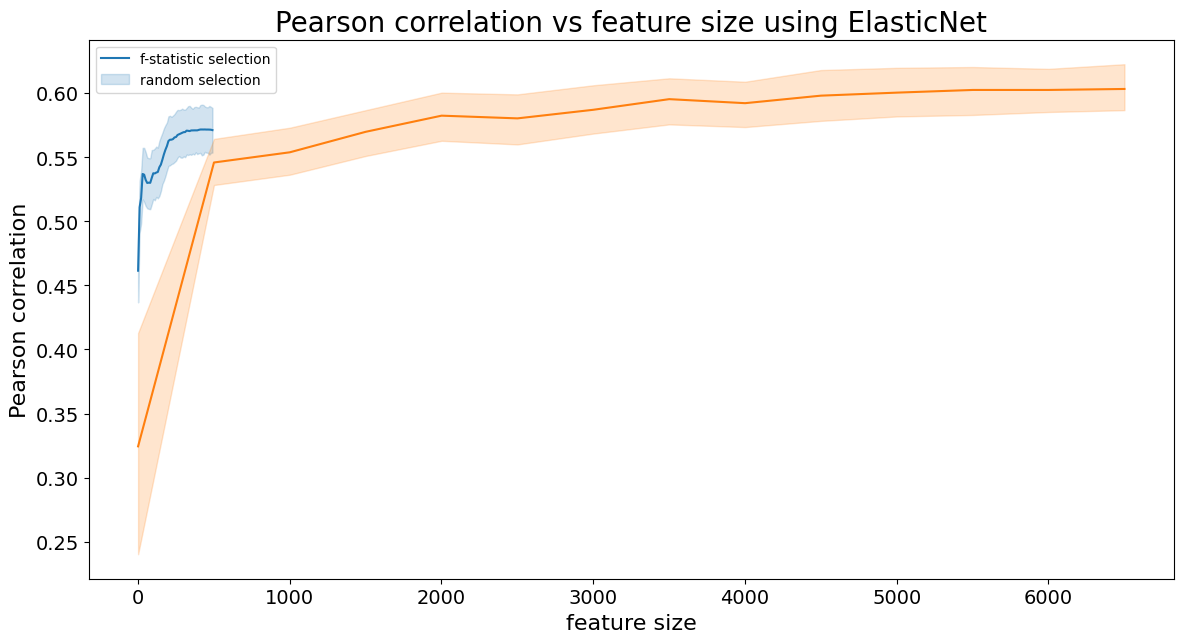

In [9]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=stat_df, ax=ax)
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
# set the legend
ax.legend(['f-statistic selection', 'random selection'])
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()

#### Feature size vs performance with network and f-regression filtering

In [10]:
nth_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]
max_gene_target_disance = 2 

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        network_features = nth_degree_neighbours[max_gene_target_disance]
        # perform feature selection on the training set
        selector = SelectKBest(f_regression, k=f_size)
        selector.fit(X_train[network_features], y_train)
        # get the selected features
        selected_features = X_train[network_features].columns[selector.get_support()]
        sel_train, sel_test = X_train[selected_features], X_test[selected_features]
        # train the model
        model = ElasticNet()
        model.fit(sel_train, y_train)
        # predict the test set
        y_pred = model.predict(sel_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # print debug info
        print(f'feature size: {f_size}, rng: {rng}, mse: {mse}, r2: {r2}, pearson_corr: {pearson_corr}')
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

net_stat_df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

feature size: 1, rng: 607106, mse: 2.203962751082483, r2: 0.09801224607987225, pearson_corr: 0.32478343530206016
feature size: 1, rng: 14466, mse: 1.7911633179727087, r2: 0.09273042132288689, pearson_corr: 0.36255901814766184
feature size: 1, rng: 925754, mse: 1.612845899669448, r2: 0.21410896567674242, pearson_corr: 0.5026954560419443
feature size: 1, rng: 741790, mse: 2.0345517558254587, r2: 0.09199832329936919, pearson_corr: 0.3235425831313486
feature size: 1, rng: 583731, mse: 2.0521307525419665, r2: 0.1273017621716569, pearson_corr: 0.3738520882711871
feature size: 1, rng: 95049, mse: 2.3820661965955634, r2: 0.05843046863426116, pearson_corr: 0.3834827690401914
feature size: 1, rng: 208247, mse: 1.8754653097808365, r2: 0.22092400610215002, pearson_corr: 0.5493794762854343
feature size: 1, rng: 725003, mse: 2.5878671003462186, r2: 0.13439184406260685, pearson_corr: 0.4363339001887866
feature size: 1, rng: 77069, mse: 2.044515934273042, r2: 0.06345992916290855, pearson_corr: 0.32820

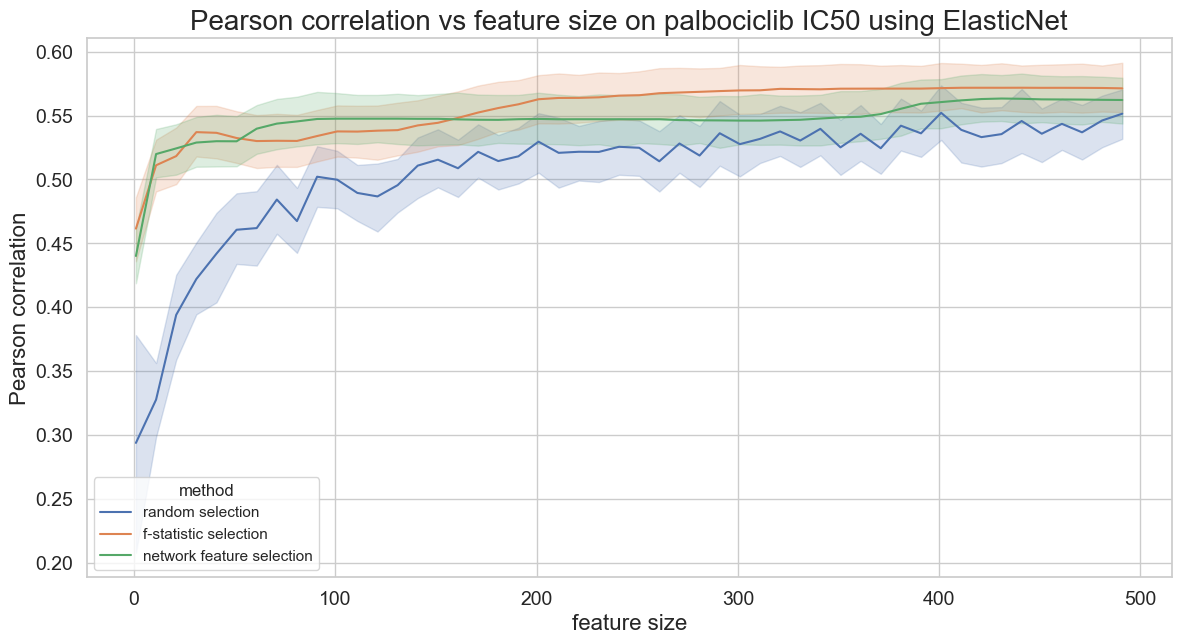

In [14]:
### plot the results

import seaborn as sns

# reindex the dataframes
plotting_df = pd.concat([df, stat_df, net_stat_df], axis=0)
plotting_df['method'] = ['random selection'] * len(df) + ['f-statistic selection'] * len(stat_df) + ['network feature selection'] * len(net_stat_df)
plotting_df.reset_index(inplace=True, drop=True)

# plot a line plot with error bars for pearson correlation
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))
# sns.lineplot(x='feature_size', y='pearson_corr', data=stat_df, ax=ax)
# sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
# sns.lineplot(x='feature_size', y='pearson_corr', data=net_stat_df, ax=ax)
sns.lineplot(x='feature_size', y='pearson_corr', hue='method', data=plotting_df, ax=ax)
# set the legend
# ax.legend(['f-statistic selection', 'network feature selection', 'random selection'])
ax.set_title('Pearson correlation vs feature size on palbociclib IC50 using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()

### Validation Framework Implementation

#### Initial Parameters

In [25]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle


## INPUTS 
# file names 
folder_path = 'data/processed-results/workbook-jun-2023/'
input_parameter_file_path = folder_path + 'input_parameters_test.pkl'
output_file_path = folder_path + 'results_test.pkl'
experiment_name = 'test'
save_input = True
save_output = True

# hyperparameters
max_gene_target_disance = 2 # specify the level of biological relevance to drug target(s)
statistical_filter_size = 100 # can be optimized using global feature dropout testing
monte_carlo_cross_validation_size = 50 # can be automatically optimized via rank impact assessment
models_used = ['ElasticNet']
models_hyperparameters = [{}]

# extra hyperparameters
statistical_filter_threshold = 0.05 # currently not in use
cv_split_size = 0.1

# generated hyperparameters
rng_seed_lists = []
for j in range(monte_carlo_cross_validation_size):
    rng_seed_lists.append(np.random.randint(100000))

def get_model_from_string(model_name, **kwargs):
    if model_name == 'ElasticNet':
        return ElasticNet(**kwargs)
    elif model_name == 'RandomForestRegressor':
        return RandomForestRegressor(**kwargs)
    elif model_name == 'SVR':
        return SVR(**kwargs)
    elif model_name == 'MLPRegressor':
        return MLPRegressor(**kwargs)
    elif model_name == 'XGBRegressor':
        return XGBRegressor(**kwargs)
    elif model_name == 'KNeighborsRegressor':
        return KNeighborsRegressor(**kwargs)
    else:
        raise ValueError(f'{model_name} is not supported')
    
nth_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]

if save_input:
    # save initial parameters as pickle 
    with open(input_parameter_file_path, 'wb') as f:
        # dump each variable individually
        pickle.dump(max_gene_target_disance, f)
        pickle.dump(statistical_filter_size, f)
        pickle.dump(monte_carlo_cross_validation_size, f)
        pickle.dump(models_used, f)
        pickle.dump(models_hyperparameters, f)
        pickle.dump(statistical_filter_threshold, f)
        pickle.dump(cv_split_size, f)
        pickle.dump(input_parameter_file_path, f)
        pickle.dump(output_file_path, f)
        pickle.dump(rng_seed_lists, f)
        pickle.dump(nth_degree_neighbours, f)
        pickle.dump(experiment_name, f)

In [26]:
network_features = nth_degree_neighbours[max_gene_target_disance]
X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size,
                                                    random_state=rng_seed_lists[0])

if statistical_filter_size > len(network_features):
    statistical_filter_size = len(network_features)
    print(f'WARNING: statistical_filter_size is too large, set to {statistical_filter_size}')

# perform feature selection on the training set
selector = SelectKBest(f_regression, k=statistical_filter_size)
selector.fit(X_train[network_features], y_train)

# get the selected features
selected_features = X_train[network_features].columns[selector.get_support()]

# get the feature importance
feature_importance = selector.scores_[selector.get_support()]

# DEBUG print the selected features and their importance
# print(f'selected features: {selected_features}')
# print(f'feature importance: {feature_importance}')

In [27]:
X_train.shape

(663, 6692)

#### Feature Selection and Consensus Feature Contribution

In [29]:
def get_shap_values(model, model_str, train_data, test_data):
    if model_str == 'RandomForestRegressor':
        explainer = shap.TreeExplainer(model, train_data)
    elif model_str == 'ElasticNet':
        explainer = shap.LinearExplainer(model, train_data)
    elif model_str == 'XGBRegressor':
        explainer = shap.TreeExplainer(model, train_data)
    elif model_str == 'MLPRegressor':
        explainer = shap.DeepExplainer(model, train_data)
    else:
        explainer = shap.KernelExplainer(model.predict, train_data)
    shap_values = explainer.shap_values(test_data)
    return shap_values

def get_network_stat_features(X_train, y_train, X_test, nth_degree_neighbours, max_gene_target_disance, statistical_filter_size):
    network_features = nth_degree_neighbours[max_gene_target_disance]
    # perform feature selection on the training set
    selector = SelectKBest(f_regression, k=statistical_filter_size)
    selector.fit(X_train[network_features], y_train)
    # get the selected features
    selected_features = X_train[network_features].columns[selector.get_support()]
    sel_train, sel_test = X_train[selected_features], X_test[selected_features]
    return selected_features, sel_train, sel_test

def get_random_features(X_train, y_train, X_test, selection_size):
    random_features = np.random.choice(X_train.columns, selection_size, replace=False)
    sel_train, sel_test = X_train[random_features], X_test[random_features]
    return random_features, sel_train, sel_test

def get_all_features(X_train, y_train, X_test):
    sel_train, sel_test = X_train, X_test
    return None, sel_train, sel_test

def get_preset_features(X_train, y_train, X_test, preset_features):
    sel_train, sel_test = X_train[preset_features], X_test[preset_features]
    return preset_features, sel_train, sel_test

verbose = True
max_feature_save_size = 1000
data_collector = []
conditions_to_test = ['network_f_regression_selection', 'whole_dataset_control', 'random_control']
conditions_to_get_feature_importance = [True, False, False]
matched_functions = [get_network_stat_features, get_all_features, get_random_features]
extra_args = [(nth_degree_neighbours, max_gene_target_disance, statistical_filter_size), (), (statistical_filter_size,)]
features_to_knockout = []

for model_str in models_used:
    for rng in rng_seed_lists:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size,
                                                            random_state=rng)

        for j, condition in enumerate(conditions_to_test):
            if verbose:
                print(f'running {model_str} with seed {rng} under {condition} conditions')
            selected_features, sel_train, sel_test = matched_functions[j](X_train, y_train, X_test, *extra_args[j])
            model = get_model_from_string(model_str, **models_hyperparameters[models_used.index(model_str)])
            model.fit(sel_train, y_train)
            y_pred = model.predict(sel_test)
            score = mean_squared_error(y_test, y_pred)
            corr, p_val = pearsonr(y_test, y_pred)
            r_squared = r2_score(y_test, y_pred)

            shap_values = None        
            if conditions_to_get_feature_importance[j]:
                shap_values = get_shap_values(model, model_str, sel_train, sel_test)

            if verbose:
                print(f'--- result: prediction correlation {corr}, p-value {p_val}, r-squared {r_squared}')

            # if sel_train and sel_test are too big, they will not be saved
            if sel_train.shape[1] > max_feature_save_size:
                sel_train = None
            if sel_test.shape[1] > max_feature_save_size:
                sel_test = None

            data_collector.append([rng, model_str, condition, selected_features, 
                                   score, corr, p_val, r_squared, shap_values, 
                                   sel_train, sel_test, y_test, y_pred])
            
if verbose:
    print('### All models ran')

df = pd.DataFrame(data_collector, columns=['rng', 'model', 'exp_condition', 'selected_features',
                                           'mse', 'corr', 'p_val', 'r_squared', 'shap_values', 
                                           'X_train', 'X_test', 'y_test', 'y_pred'])

if save_output:
    with open(output_file_path, 'wb') as f:
        pickle.dump(df, f)

if verbose:
    print('### Results saved')

running ElasticNet with seed 35980 under network_f_regression_selection conditions
--- result: prediction correlation 0.42631838541804407, p-value 0.00015228094835403796, r-squared 0.17909305163197253
running ElasticNet with seed 35980 under whole_dataset_control conditions
--- result: prediction correlation 0.4491860469808589, p-value 5.9595179293369086e-05, r-squared 0.19487261646415388
running ElasticNet with seed 35980 under random_control conditions
--- result: prediction correlation 0.39908504410997614, p-value 0.0004280441159118324, r-squared 0.1579731139374888
running ElasticNet with seed 4935 under network_f_regression_selection conditions
--- result: prediction correlation 0.5197982382387158, p-value 2.07412397575869e-06, r-squared 0.2613502325367397
running ElasticNet with seed 4935 under whole_dataset_control conditions
--- result: prediction correlation 0.5403617616165618, p-value 6.717947837950339e-07, r-squared 0.2850333036664421
running ElasticNet with seed 4935 under r

In [30]:
df.head()


,rng,model,exp_condition,selected_features,mse,corr,p_val,r_squared,shap_values,X_train,X_test,y_test,y_pred
0,35980,ElasticNet,network_f_regression_selection,"Index(['P08238;HS90B_HUMAN', 'P62826;RAN_HUMAN...",1.657382,0.426318,1.522809e-04,0.179093,"[[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0....",P08238;HS90B_HUMAN P62826;RAN_HUMA...,P08238;HS90B_HUMAN P62826;RAN_HUMA...,SIDM01110 2.772303 SIDM00422 4.509105 SI...,"[3.93317268259452, 2.6813816790007574, 4.19231..."
1,35980,ElasticNet,whole_dataset_control,None,1.625523,0.449186,5.959518e-05,0.194873,None,None,None,SIDM01110 2.772303 SIDM00422 4.509105 SI...,"[3.9193501162736055, 2.62084995120491, 4.05429..."
2,35980,ElasticNet,random_control,"[Q8IXQ5;KLHL7_HUMAN, Q96HR8;NAF1_HUMAN, O75051...",1.700022,0.399085,4.280441e-04,0.157973,None,Q8IXQ5;KLHL7_HUMAN Q96HR8;NAF1_HUM...,Q8IXQ5;KLHL7_HUMAN Q96HR8;NAF1_HUM...,SIDM01110 2.772303 SIDM00422 4.509105 SI...,"[3.0951768841134624, 3.1314086428340024, 3.775..."
3,4935,ElasticNet,network_f_regression_selection,"Index(['P08238;HS90B_HUMAN', 'P51608;MECP2_HUM...",1.537363,0.519798,2.074124e-06,0.261350,"[[0.0, 0.0, 0.0, 0.0, 0.008144565006176541, 0....",P08238;HS90B_HUMAN P51608;MECP2_HU...,P08238;HS90B_HUMAN P51608;MECP2_HU...,SIDM01135 3.397201 SIDM00989 2.016698 SI...,"[4.125809407346743, 4.2025558369082745, 3.4556..."
4,4935,ElasticNet,whole_dataset_control,None,1.488071,0.540362,6.717948e-07,0.285033,None,None,None,SIDM01135 3.397201 SIDM00989 2.016698 SI...,"[4.283988183840145, 4.3136796192553195, 3.6682..."


### Computing mean contribution
### Plotting mean contribution


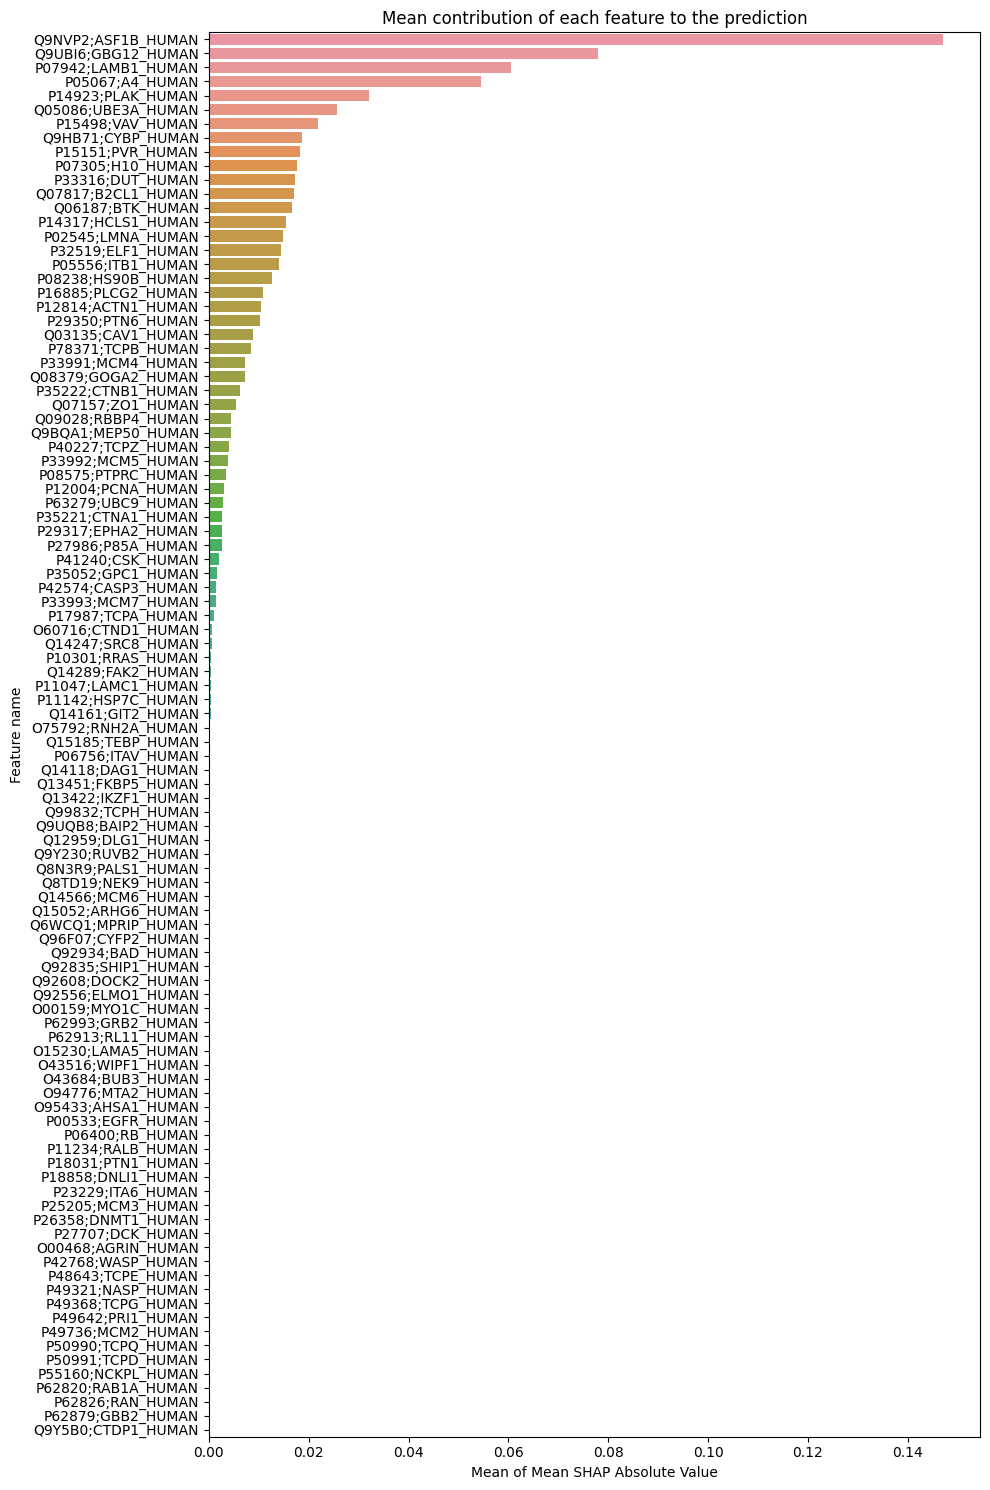

In [39]:
from toolkit import *

print('### Computing mean contribution')
mean_shap_values = get_mean_contribution(df)

# plot the mean shap values

import matplotlib.pyplot as plt
import seaborn as sns

print('### Plotting mean contribution')
plt.figure(figsize=(10, 15))
sns.barplot(x=mean_shap_values.values, y=mean_shap_values.index)
plt.title('Mean contribution of each feature to the prediction')
plt.xlabel('Mean of Mean SHAP Absolute Value')
plt.ylabel('Feature name')
plt.tight_layout()
# plt.savefig('mean_contribution.png', dpi=300)
plt.show()

#### in silico Knockout Validation 

are the features really important? Knock them out and check if the model performance decreases, compare it with a random feature knockout. If not, then what new features are contributing to the model performance?

In [66]:
# get the feature with the highest mean shap value
highest_mean_shap = mean_shap_values.index[0]

# get all of the consensus features
consensus_features = [x for x in mean_shap_values.index]

In [94]:
knockout_features = []
for feature in consensus_features:
    if feature != highest_mean_shap:
        knockout_features.append(feature)

# knockout top 10 features with the highest feature importance
knockout_features_2 = consensus_features.copy()
# remove the first 10 elements in the list
knockout_features_2 = knockout_features_2[10:]

verbose = True
max_feature_save_size = 1000
data_collector = []
conditions_to_test = ['knockout-1', 'knockout-2']
conditions_to_get_feature_importance = [True, True]
matched_functions = [get_preset_features, get_preset_features]
extra_args = [(knockout_features,), (knockout_features_2,)]

from toolkit import *
new_df = run_bulk_test(conditions_to_test, conditions_to_get_feature_importance, matched_functions, extra_args, 
                       models_used, models_hyperparameters, rng_seed_lists, 
                       feature_data, label_data, cv_split_size, 
                       save_output=False)

running ElasticNet with seed 35980 under knockout-1 conditions
--- result: prediction correlation 0.42631000452424095, p-value 0.0001523314743086148, r-squared 0.17908606294334295
running ElasticNet with seed 35980 under knockout-2 conditions
--- result: prediction correlation 0.46227612710476107, p-value 3.377561081018031e-05, r-squared 0.21244936197098419
running ElasticNet with seed 4935 under knockout-1 conditions
--- result: prediction correlation 0.5197944972493612, p-value 2.0745355653352755e-06, r-squared 0.2613473208862196
running ElasticNet with seed 4935 under knockout-2 conditions
--- result: prediction correlation 0.49903665103824224, p-value 6.021068546436855e-06, r-squared 0.2387112873530869
running ElasticNet with seed 31946 under knockout-1 conditions
--- result: prediction correlation 0.5750397764599674, p-value 8.39311130227774e-08, r-squared 0.21763076554198557
running ElasticNet with seed 31946 under knockout-2 conditions
--- result: prediction correlation 0.604206

In [95]:
knockout_mean_shap_values = get_mean_contribution(new_df, condition='knockout-1')
knockout_mean_shap_values_2 = get_mean_contribution(new_df, condition='knockout-2')

In [106]:
mean_shap_values_1 = mean_shap_values
mean_shap_values_2 = knockout_mean_shap_values


def get_diff_between_feature_contributions(shap_df1: pd.DataFrame, shap_df2: pd.DataFrame):
    # compute the difference in mean shap values for each feature
    diff = shap_df2 - shap_df1
    diff = diff.sort_values(ascending=False)
    return diff

def get_abs_sum_for_feature_contributions(shap_df):
    return shap_df.abs().sum()

total_sum_og = get_abs_sum_for_feature_contributions(mean_shap_values)
total_sum_ko = get_abs_sum_for_feature_contributions(knockout_mean_shap_values)
total_sum_ko_2 = get_abs_sum_for_feature_contributions(knockout_mean_shap_values_2)

print(f'### Total absolute sum of mean shap values: {total_sum_og}')
print(f'### Total absolute sum of mean shap values for knockout 1: {total_sum_ko}')
print(f'### Total absolute sum of mean shap values for knockout 2: {total_sum_ko_2}')

# compute the total absolute change in mean shap values by summing the absolute change for each feature
diff = get_diff_between_feature_contributions(mean_shap_values_1, mean_shap_values_2)
total_abs_change = get_abs_sum_for_feature_contributions(diff)
print(f'### Total absolute change in mean shap values: {total_abs_change}')

# compute total absolute change in mean shap values for each feature between knockout 2 and original 
diff2 = get_diff_between_feature_contributions(mean_shap_values_1, knockout_mean_shap_values_2)
abs_change_2 = get_abs_sum_for_feature_contributions(diff2)
print(f'### Total absolute change in mean shap values for knockout 2: {abs_change_2}')


from scipy.stats import ttest_rel
def report_ttest_for_performance(df1, df2, condition1, condition2, verbose=True):
    if verbose:
        print(f'### Running t-test for performance between {condition1} and {condition2}')
        print(f'Mean performance of {condition1}: {df1[df1["exp_condition"]==condition1]["corr"].mean():.3f}, variance: {df1[df1["exp_condition"]==condition1]["corr"].var():.3f}')
        print(f'Mean performance of {condition2}: {df2[df2["exp_condition"]==condition2]["corr"].mean():.3f}, variance: {df2[df2["exp_condition"]==condition2]["corr"].var():.3f}')
    t_stat, p_val = ttest_rel(df1[df1['exp_condition']==condition1]['corr'], df2[df2['exp_condition']==condition2]['corr'])
    if verbose:
        print(f'### t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}')
    return t_stat, p_val

t_stat, p_val = report_ttest_for_performance(df, new_df, 'network_f_regression_selection', 'knockout-1')

t_stat, p_val = report_ttest_for_performance(df, new_df, 'network_f_regression_selection', 'knockout-2')

### Total absolute sum of mean shap values: 0.7171731836118116
### Total absolute sum of mean shap values for knockout 1: 0.7171289267160776
### Total absolute sum of mean shap values for knockout 2: 0.6522579043523655
### Total absolute change in mean shap values: 0.8578939301758111
### Total absolute change in mean shap values for knockout 2: 0.7098632897334386
### Running t-test for performance between network_f_regression_selection and knockout-1
Mean performance of network_f_regression_selection: 0.544, variance: 0.006
Mean performance of knockout-1: 0.544, variance: 0.006
### t-statistic: -0.545, p-value: 0.588
### Running t-test for performance between network_f_regression_selection and knockout-2
Mean performance of network_f_regression_selection: 0.544, variance: 0.006
Mean performance of knockout-2: 0.547, variance: 0.006
### t-statistic: -0.624, p-value: 0.535


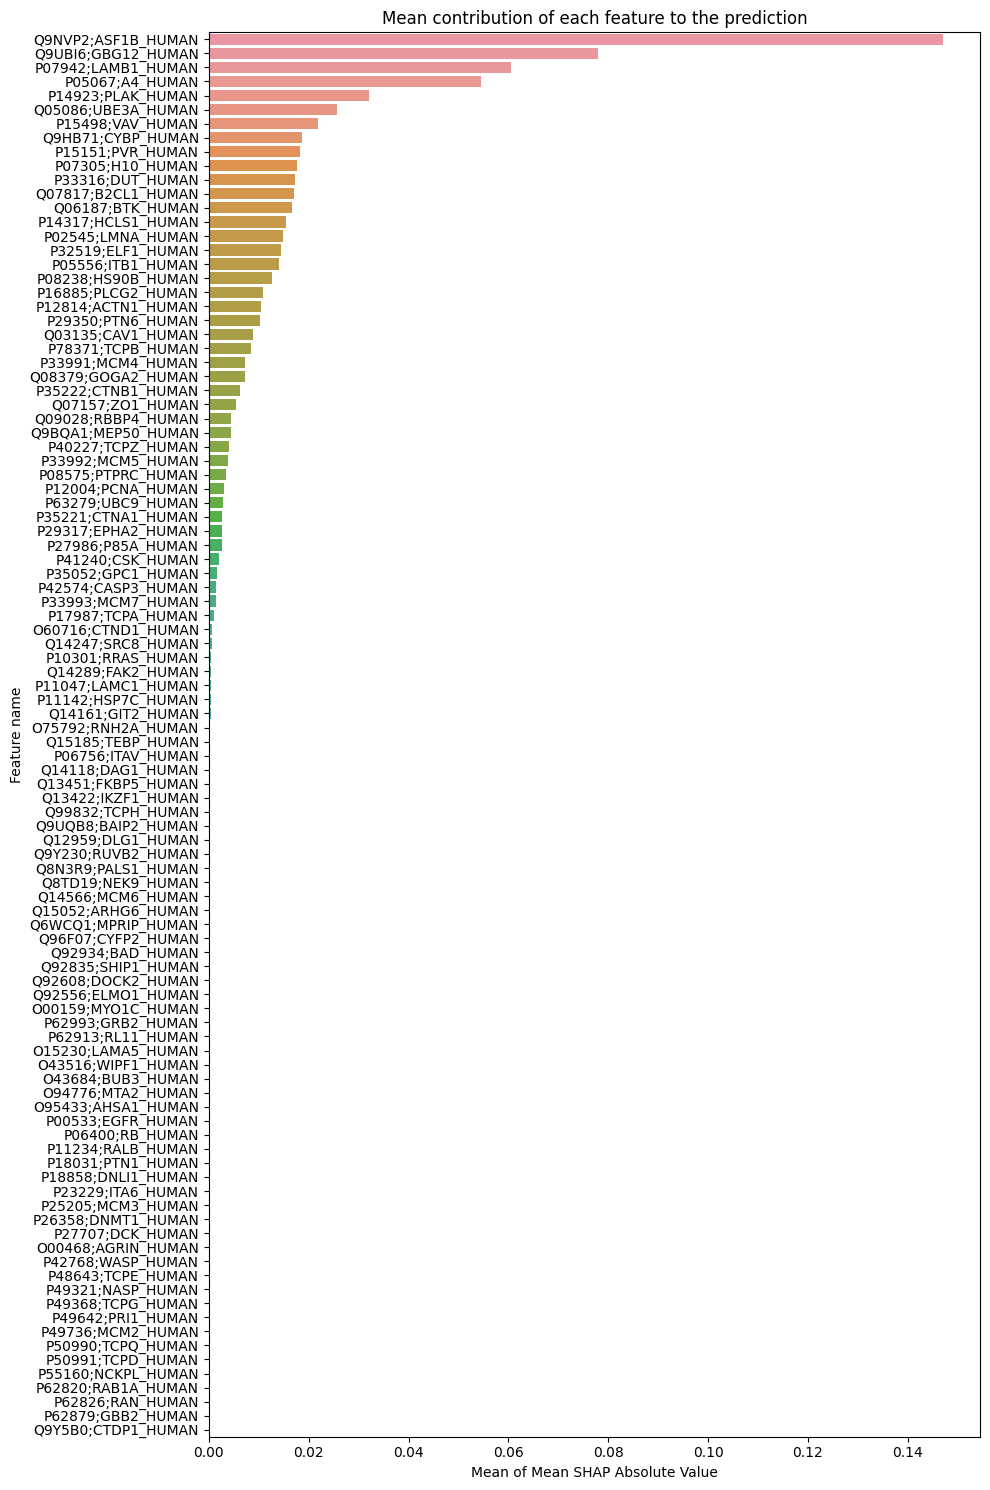

In [107]:
# plot the mean shap values

import matplotlib.pyplot as plt
import seaborn as sns


def plot_mean_shap_value_df(mean_shap_values, title):
    fig, ax = plt.subplots(figsize=(10, 15))
    sns.barplot(x=mean_shap_values.values, y=mean_shap_values.index, ax=ax)
    plt.title(title)
    plt.xlabel('Mean of Mean SHAP Absolute Value')
    plt.ylabel('Feature name')
    plt.tight_layout()
    # plt.savefig('mean_contribution.png', dpi=300)
    return fig, ax

fig, ax = plot_mean_shap_value_df(mean_shap_values_1, 'Mean contribution of each feature to the prediction')
plt.show()

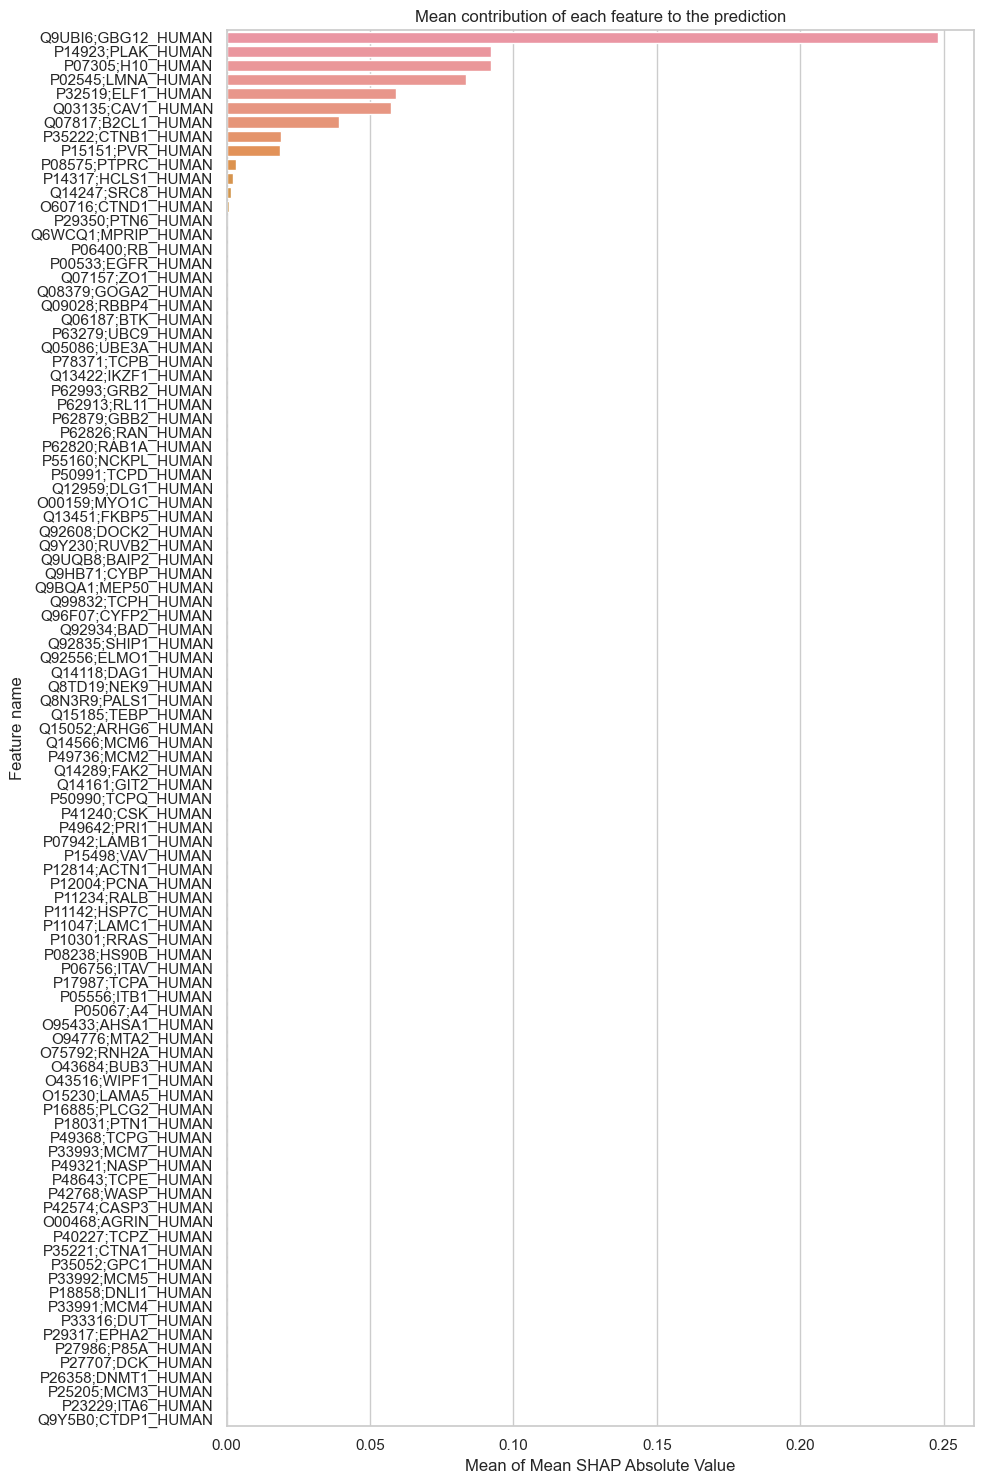

In [139]:
plot_mean_shap_value_df(knockout_mean_shap_values, 'Mean contribution of each feature to the prediction')
plt.show()

#### Calculate the difference in mean contribution of features between two mean shap values

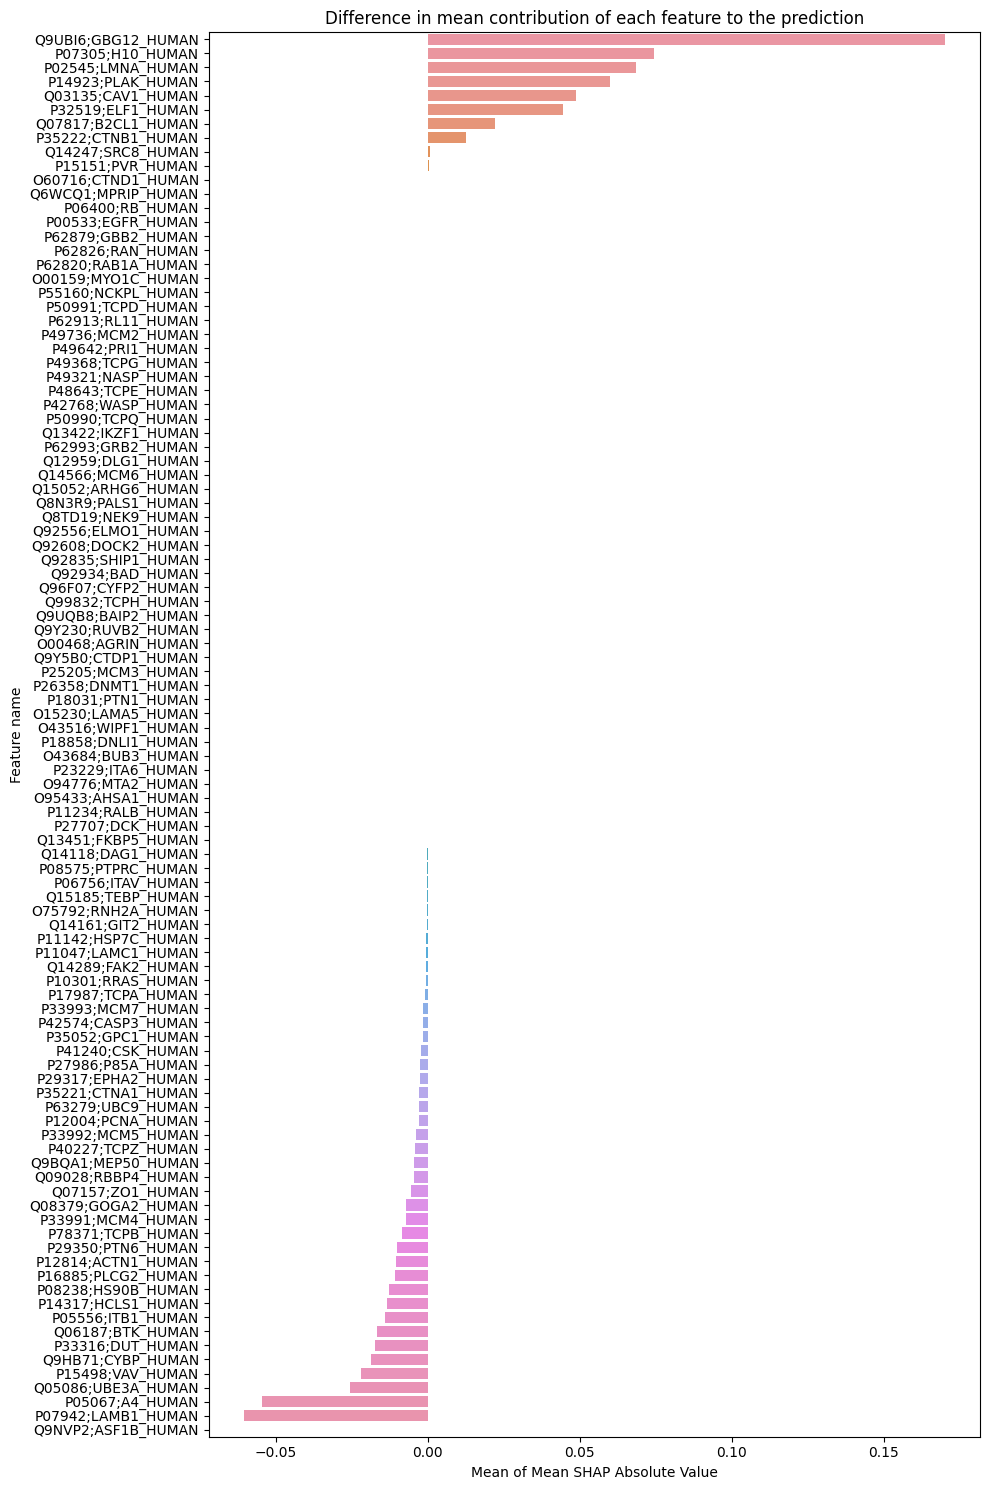

In [109]:
fig, ax = plot_mean_shap_value_df(diff, 'Difference in mean contribution of each feature to the prediction')
plt.show()


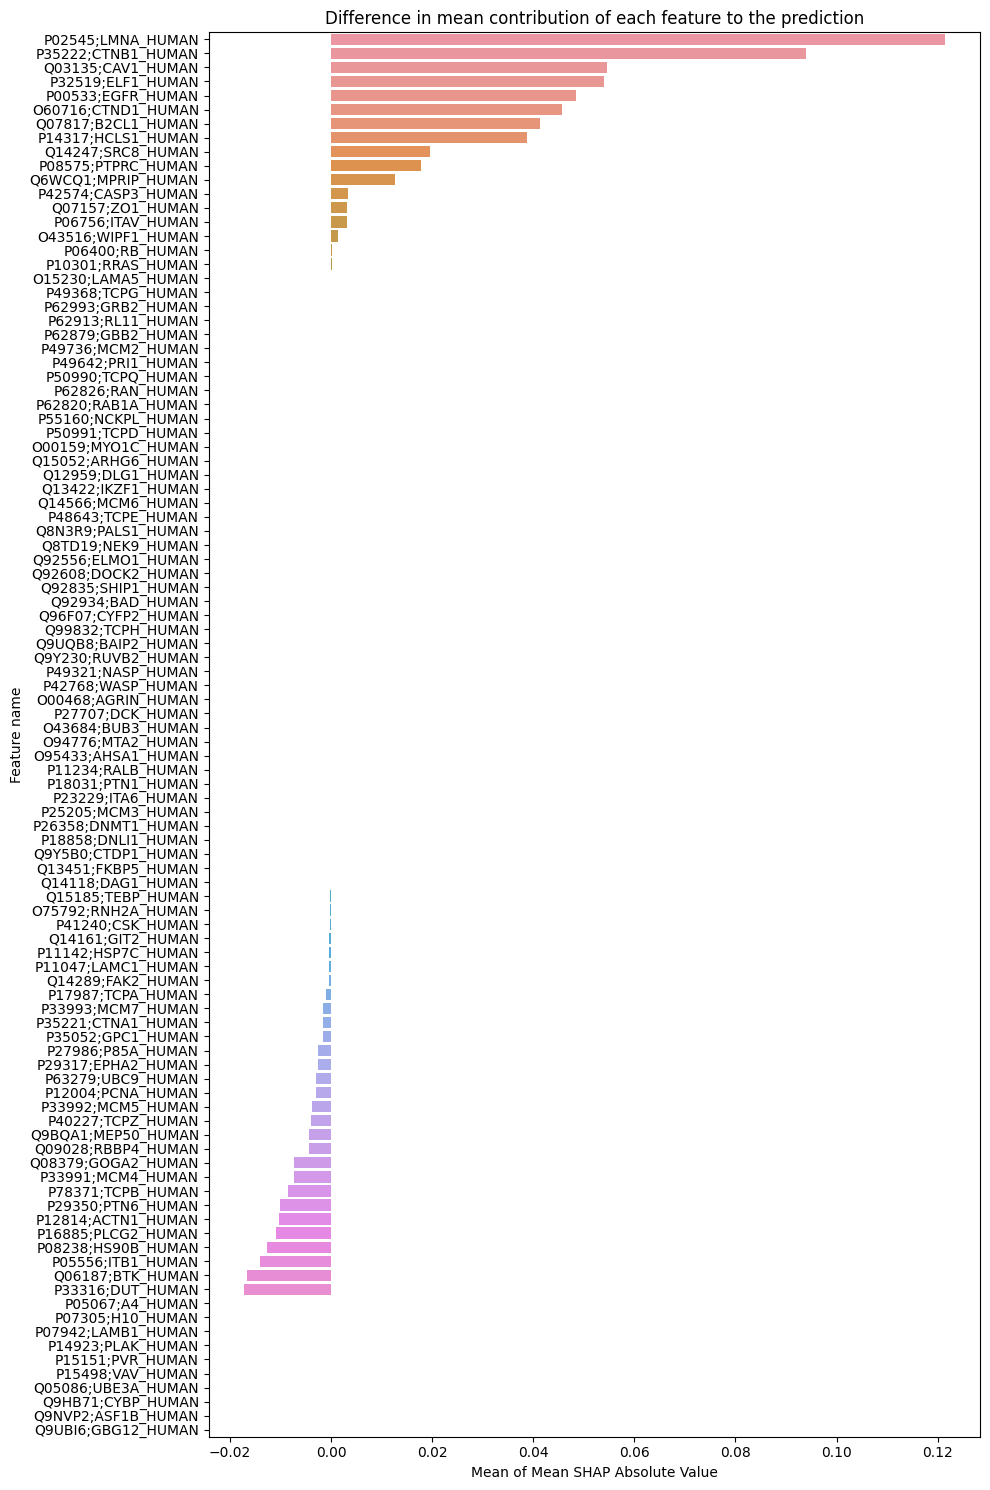

In [110]:
fig, ax = plot_mean_shap_value_df(diff2, 'Difference in mean contribution of each feature to the prediction')
plt.show()

conclusion: when one protein gets knocked out, another protein of statistically similar shape will take its place and contribute to the model performance.

mean absolute change in shap value between two mean shap values is highly interesting and should be explored further. Mean absolute change, in this case, represents the total perturbation effect of any n-sized feature set on the holistic feature contribution landscape. This will allow for the quantification, and visualisation for the explanation of model performance between different *in silico* experimental conditions.

model performance between different conditions can now be directly compared using pearson correlation coefficient, r2 and mean squared error.

One interesting hypothesis is that when mean absolute change in feature contribution is low between two conditions, model performance drops proportionally to the knocked out features. This can be that the model can no longer compensate for the loss of the feature by adjusting contribution of still-existing features and the model performance drops.

This feature selection approach is model-agnostic and can be applied to any model. It is scalable with increased computational power and can be used to compare model performance between different conditions. Filtering selection and in addition, even the global feature importance approaches can be substituted (e.g. lime) 

We can also select any n-feature combination, knock them out and compare the model performance with the original model performance, while similarly comparing the mean absolute change in feature contribution between the two conditions. If n is small (e.g. less than 3), we can experimentally validate the results using in vitro experiments. Specifically, once the n-feature combination is selected, we assess their correlation with LN_IC50 of the drug of interest. If a featuer correlation is *positive*, then the cell lines are resistant to drug when expression is high, *knockout* of the feature should *increase* the drug sensitivity. If a feature correlation is *negative*, then *overexpression* of the feature should *increase* the drug sensitivity.